## A) Regularización y regresión con variables latentes

Con los datos `Acetylene` de la práctica de regularización, y partiendo del modelo del artículo original de Marquardt y Snee, que usa como predictores los términos principales, `temp`, `ratio`, `time`, junto con los términos cuadráticos `I(temp^2)`, `I(ratio^2)`, `I(time^2)` y las interaciones de segundo orden `temp:ratio`, `temp:time`, `ratio:time`. 

In [12]:
# Modelo del artículo original de Marquardt y Snee

#install.packages("genridge",dependencies=TRUE,repos="https://cloud.r-project.org")
#install.packages("car",dependencies=TRUE,repos="https://cloud.r-project.org")
#install.packages("glmnet",dependencies=TRUE,repos="https://cloud.r-project.org")
require(genridge)
require(car)
require(glmnet)

data(Acetylene)
str(Acetylene)

Acetylene.lm<-lm(yield~temp+ratio+time+I(temp^2)+I(ratio^2)+I(time^2)+temp:ratio+temp:time+ratio:time, data=Acetylene)
summary(Acetylene.lm)

'data.frame':	16 obs. of  4 variables:
 $ yield: num  49 50.2 50.5 48.5 47.5 44.5 28 31.5 34.5 35 ...
 $ temp : int  1300 1300 1300 1300 1300 1300 1200 1200 1200 1200 ...
 $ ratio: num  7.5 9 11 13.5 17 23 5.3 7.5 11 13.5 ...
 $ time : num  0.012 0.012 0.0115 0.013 0.0135 0.012 0.04 0.038 0.032 0.026 ...



Call:
lm(formula = yield ~ temp + ratio + time + I(temp^2) + I(ratio^2) + 
    I(time^2) + temp:ratio + temp:time + ratio:time, data = Acetylene)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3499 -0.3411  0.1297  0.5011  0.6720 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -3.617e+03  3.136e+03  -1.153  0.29260   
temp         5.324e+00  4.879e+00   1.091  0.31706   
ratio        1.924e+01  4.303e+00   4.472  0.00423 **
time         1.377e+04  1.045e+04   1.318  0.23572   
I(temp^2)   -1.927e-03  1.896e-03  -1.016  0.34874   
I(ratio^2)  -3.034e-02  1.168e-02  -2.597  0.04084 * 
I(time^2)   -1.158e+04  7.699e+03  -1.504  0.18318   
temp:ratio  -1.414e-02  3.212e-03  -4.404  0.00455 **
temp:time   -1.058e+01  8.241e+00  -1.283  0.24666   
ratio:time  -2.103e+01  9.241e+00  -2.276  0.06312 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9014 on 6 degrees of freedom
Multiple R-squared:  0.997

### (1) Regresión _ridge_ 

(decidiendo el valor adecuado del parámetro)


In [29]:
y<- Acetylene$yield
X0<-model.matrix(Acetylene.lm)[,-1]
lambda <- 10^seq(3, -2, by = -.1)
ridge.mod <- glmnet(X0,y,alpha=0,lambda=lambda)
ridge.cv <- cv.glmnet(X0,y,alpha=0,lambda=lambda)

Warning message:
"Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold"

Aplicada una regresion ridge para una serie de lambdas, usamos CV para obtener un factor optimo.

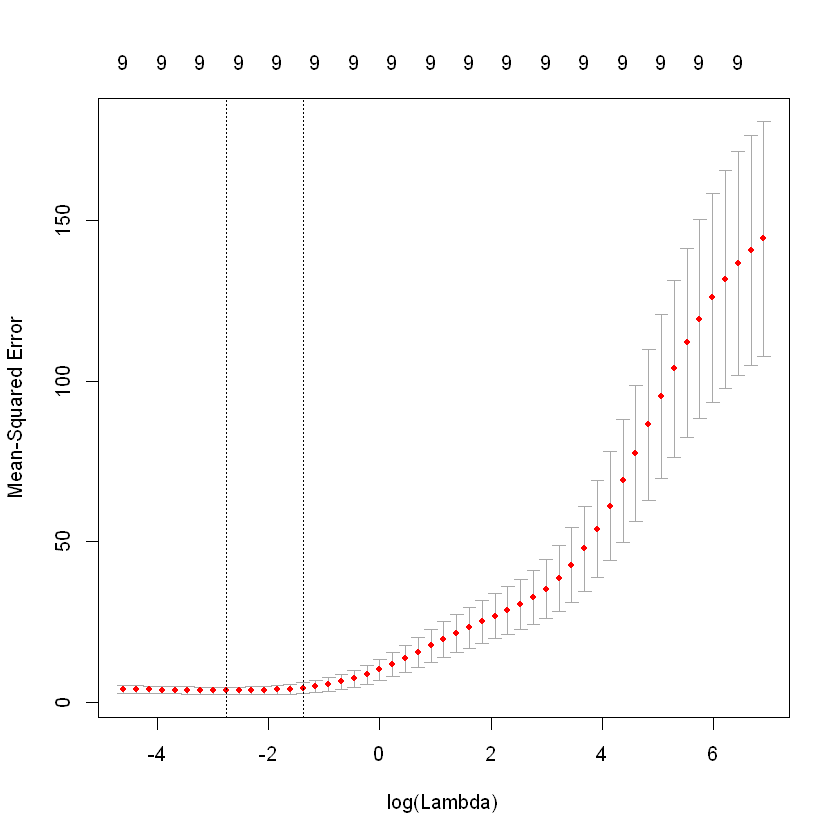

In [31]:
plot(ridge.cv)

Obtenemos la lambda optimo que minimiza el MSE

[1] 0.063

[1] -2.763

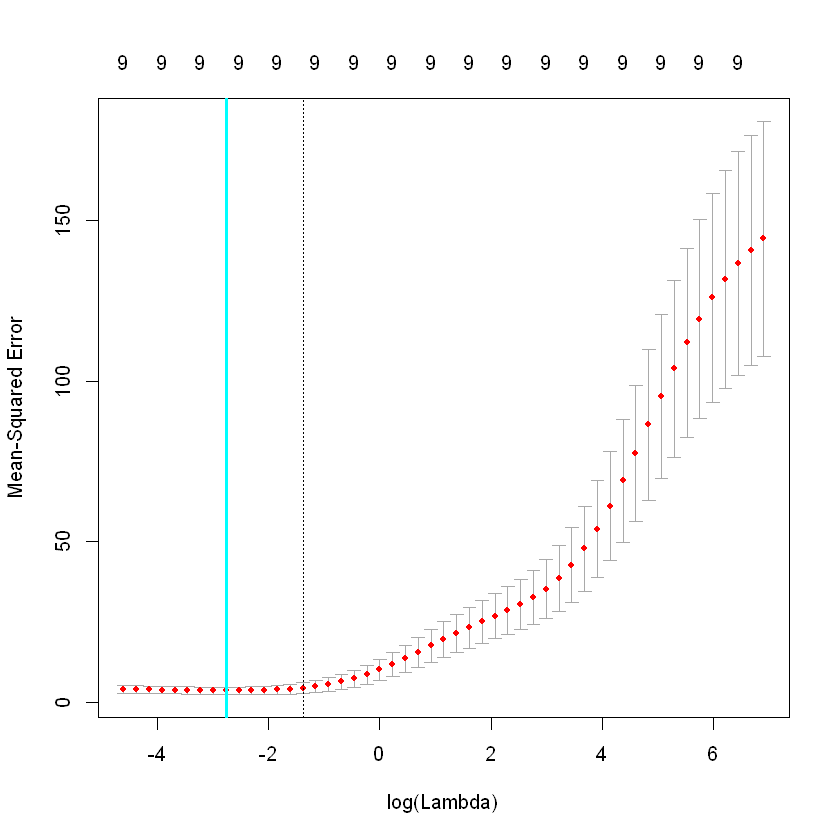

In [32]:
bestlam<-ridge.cv$lambda.min
round(bestlam,3)
round(log(bestlam),3)
plot(ridge.cv)
abline(v=log(bestlam),lwd=3,col="cyan")

In [44]:
ridge.pred<-predict(ridge.mod,s=bestlam,newx=X0)
round(mean((ridge.pred-y)^2),3)
out<-glmnet(X0,y,alpha=0)
ridge.coef<-predict(out,type="coefficients",s=bestlam)
r.ridge<-round(ridge.coef,3)
r.ridge

[1] 1.458

10 x 1 sparse Matrix of class "dgCMatrix"
                   1
(Intercept)  -59.715
temp           0.052
ratio          0.156
time         -71.519
I(temp^2)      0.000
I(ratio^2)    -0.009
I(time^2)   -123.465
temp:ratio     0.000
temp:time     -0.075
ratio:time     9.542

El resultado de la regresion Ridge dice que "I(temp^2)" y "temp:ratio" son demasiado dependientes del resto de variables, han de ser descartados.

### (2) Regresión en componentes principales (PCR)

 (decidiendo el número de componentes a incluir en el modelo)


In [46]:
#install.packages("pls",dependencies=TRUE,repos="https://cloud.r-project.org")
require(pls)

Aplicamos un PCR sobre los datos

In [48]:
set.seed(2)
pcr.fit<-pcr(yield~temp+ratio+time+I(temp^2)+I(ratio^2)+I(time^2)+temp:ratio+temp:time+ratio:time, data=Acetylene,scale=TRUE,validation="CV")
summary(pcr.fit)

Data: 	X dimension: 16 9 
	Y dimension: 16 1
Fit method: svdpc
Number of components considered: 9

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           12.29    4.727    5.356    5.612    1.941    2.085    2.293
adjCV        12.29    4.642    5.282    5.531    1.902    2.030    2.218
       7 comps  8 comps  9 comps
CV       2.502    6.240    8.631
adjCV    2.419    5.852    8.087

TRAINING: % variance explained
       1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X        63.39    96.49    98.39    99.73    99.97   100.00   100.00   100.00
yield    86.29    86.41    88.60    98.69    98.87    98.97    99.03    99.72
       9 comps
X       100.00
yield    99.77


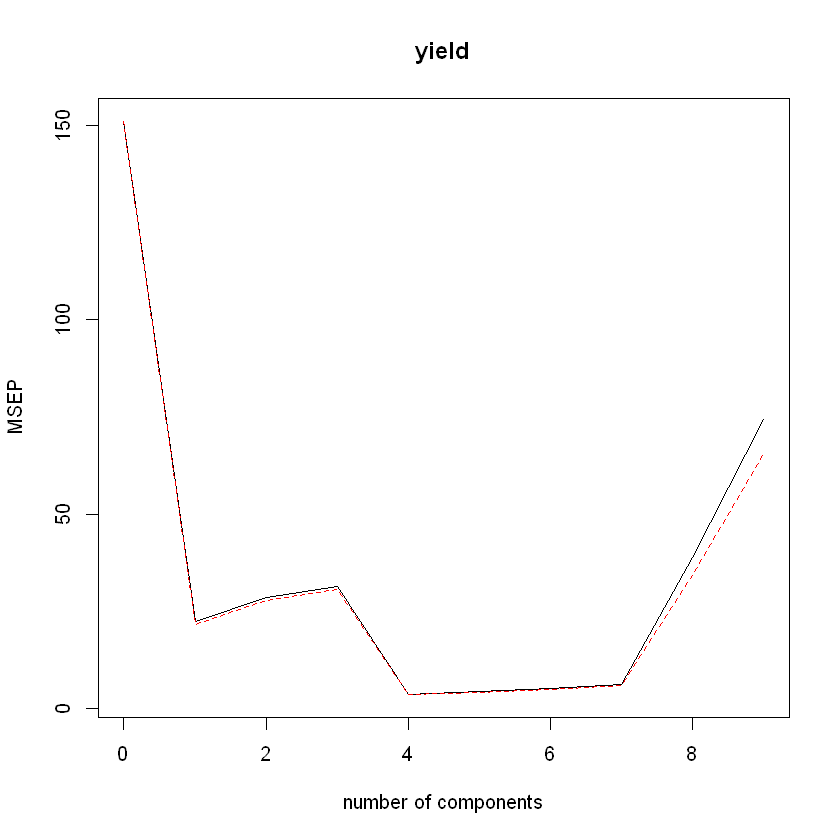

In [49]:
validationplot(pcr.fit,val.type="MSEP")

El numero de componentes que minimizan el MSE es 4, es el valor que usaremos en el predictor

In [51]:
pcr.pred<-predict(pcr.fit,X0,ncomp=4)
round(mean((pcr.pred-y)^2),3)
pcr.fit<-pcr(y~X0,scale=TRUE,ncomp=4)
summary(pcr.fit)

[1] 1.735

Data: 	X dimension: 16 9 
	Y dimension: 16 1
Fit method: svdpc
Number of components considered: 4
TRAINING: % variance explained
   1 comps  2 comps  3 comps  4 comps
X    63.39    96.49    98.39    99.73
y    86.29    86.41    88.60    98.69


## B) Árboles de predicción

Con _sólo uno de los dos datasets_ `spam` y `zip` (reunión de `zip.train` y `zip.test`), construir un árbol de clasificación. Podarlo adecuadamente según la probabilidad de error calculada mediante uno de los métodos conocidos
(hold-out, k-fold, LOO, bootstrap).

In [ ]:
#install.packages("tree",dependencies=TRUE,repos="https://cloud.r-project.org")
require(tree)

Uso los datos sobre Spam del dataset "spam" y el metodo de poda aplica k-fold cross validation (en parte porque ya he visto un ejemplo de como usar cv.tree, y porque el CV siempre es buena opcion)

In [ ]:
require(ElemStatLearn)

data(spam)
true_spam<-spam$spam

El primer arbol generado sobre todo el df nos da 13 hojas/posibles finales, y 12 comparaciones. Me gustaria encontrar un arbol mas pequeño con un error en clasificacion lo mas pequeño posible.

Por eso lo podare usando k-fold CV para seleccionar las ramas que menos valgan la pena y eliminarlas.

In [ ]:
spam.tree<-tree(spam~.,spam)
plot(spam.tree)
text(spam.tree,cex=0.6)
spam.pred<-predict(spam.tree,spam,type="class")
table(spam.pred,true_spam)
#(2640+1581)/4601 = 0.9174

La K del k-fold la ponemos en 10 y observamos donde se observan las variaciones mas importantes, que son 5 y 8. (elijo el valor 10 a dedo ya que me parece un valor bueno, habria elejido un valor entre 10 o 7)

In [ ]:
set.seed(3)


spam.tree.CV <-cv.tree(spam.tree,K=10,FUN=prune.tree,method="deviance")

par(mfrow=c(1,2))
plot(spam.tree.CV$size,spam.tree.CV$dev,type="b")
plot(spam.tree.CV$k,spam.tree.CV$dev,type="b")

Los valores se estabilizan en 5 y 8, mas alla de estos valores vemos que vuelve a caer en 13 (el tamaño del original). Estos seran los valores que comprobare al hacer la poda para ver con cual me quedo.

Comprobamos el error en la clasificacion resultante y los comparamos entre ellos para ver cual es mejor.

In [ ]:
par(mfrow=c(1,2))


prune.spam1<-prune.tree(spam.tree,method="deviance",best=5)
plot(prune.spam1)
text(prune.spam1,cex=0.6)
spam.pred1<-predict(prune.spam1,spam,type="class")
print("best = 5")
table(spam.pred1,true_spam)
#(2688+1290)/4601 = 0.8646

prune.spam2<-prune.tree(spam.tree,method="deviance",best=8)
plot(prune.spam2)
text(prune.spam2,cex=0.6)
spam.pred2<-predict(prune.spam2,spam,type="class")
print("best = 10")
table(spam.pred2,true_spam)
#(2641+1489)/4601 = 0.8976

Vemos que 5 es menos de la mitad del tamaño original (13) y tiene resultados bastante buenos. 8 es un tamaño mas proximo al original y pierde muy poquito frente al original.

Si queremos minimizar el tamaño o coste de clasificacion el mejor es usar el valor 5. Si queremos ahorrar costes pero tener resultados similares al "no podado" el mejor es tamaño 8.